In [1]:
import sys
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
import virtualTB

env = gym.make('VirtualTB-v0')
env_action_space = env.action_space.shape[0]


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class OUNoise:

    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state * self.scale
    

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)

        y = (x - mean) / (std + self.eps)
        if self.affine:
#             shape = [1, -1] + [1] * (x.dim() - 2)
            shape = [1, 1, -1]
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

nn.LayerNorm = LayerNorm


class Actor(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Actor, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]
        
        self.c1 = nn.Conv1d(1, 1, kernel_size=4, dilation=9, stride=1)
        self.l1 = nn.LSTM(64, hidden_size, batch_first=True)
        self.ln1 = nn.LayerNorm(hidden_size)

        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

        self.mu = nn.Linear(hidden_size, num_outputs)
        self.mu.weight.data.mul_(0.1)
        self.mu.bias.data.mul_(0.1)

    def forward(self, inputs, h):
#         print('input: ', inputs.shape)
        x = inputs
        x = self.c1(x)
        x, h = self.l1(x, h)
#         print('x: ', x.shape)
#         print('h: ', h[0].shape)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.ln2(x)
        x = F.relu(x)
        mu = torch.tanh(self.mu(x))
        return mu, h

class Critic(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Critic, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]
        
        self.c1 = nn.Conv1d(1, 1, kernel_size=4, dilation=9, stride=1)
        self.l1 = nn.LSTM(64, hidden_size, batch_first=True)
        self.ln1 = nn.LayerNorm(hidden_size)

        self.linear2 = nn.Linear(hidden_size+num_outputs, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

        self.V = nn.Linear(hidden_size, 1)
        self.V.weight.data.mul_(0.1)
        self.V.bias.data.mul_(0.1)

    def forward(self, inputs, actions, h):
        x = inputs
        x = self.c1(x)
        x, h = self.l1(x, h)
        x = self.ln1(x)
        x = F.relu(x)
#         print('x1:', x.shape)
#         print('action:', actions.shape)
        x = torch.cat((x, actions), 2)
        x = self.linear2(x)
        x = self.ln2(x)
        x = F.relu(x)
        V = self.V(x)
        return V

class DDPG(object):
    def __init__(self, gamma, tau, hidden_size, num_inputs, action_space, device):

        self.num_inputs = num_inputs
        self.action_space = action_space
        self.device = device

        self.actor = Actor(hidden_size, self.num_inputs, self.action_space).to(device)
        self.actor_target = Actor(hidden_size, self.num_inputs, self.action_space).to(device)
        self.actor_perturbed = Actor(hidden_size, self.num_inputs, self.action_space).to(device)
        self.actor_optim = Adam(self.actor.parameters(), lr=1e-5)

        self.critic = Critic(hidden_size, self.num_inputs, self.action_space).to(device)
        self.critic_target = Critic(hidden_size, self.num_inputs, self.action_space).to(device)
        self.critic_optim = Adam(self.critic.parameters(), lr=1e-4)
        
        self.actor.train()
        self.actor_perturbed.train()
        self.critic.train()

        self.gamma = gamma
        self.tau = tau
        self.update_counter = 0

        hard_update(self.actor_target, self.actor)  # Make sure target is with the same weight
        hard_update(self.critic_target, self.critic)


    def get_initial_states(self):
        h_0, c_0 = None, None
        h_0 = torch.zeros((
            self.actor.l1.num_layers,
            1,
            self.actor.l1.hidden_size),
            dtype=torch.float)
        h_0 = h_0.to(device=device)

        c_0 = torch.zeros((
            self.actor.l1.num_layers,
            1,
            self.actor.l1.hidden_size),
            dtype=torch.float)
        c_0 = c_0.to(device=device)
        return (h_0, c_0)
    
        
    def select_action(self, state, h, action_noise=None, param_noise=None):
        self.actor.eval()
        if param_noise is not None: 
            mu, h = self.actor_perturbed((Variable(state).to(device)), h)
        else:
            mu, h = self.actor((Variable(state).to(device)), h)

        self.actor.train()
        mu = mu.data

        if action_noise is not None:
            mu += torch.Tensor(action_noise.noise()).to(device)

        return mu.clamp(-1, 1), h


    def update_parameters(self, batch):
#         torch.backends.cudnn.enabled = False
#         if self.actor.training:
#             print('a training')
#         if self.critic.training:
#             print('c training')
        state_batch = Variable(torch.cat(batch.state).unsqueeze(1))
        action_batch = Variable(torch.cat(batch.action))
        reward_batch = Variable(torch.cat(batch.reward).unsqueeze(1))
        mask_batch = Variable(torch.cat(batch.mask).unsqueeze(1))
        next_state_batch = Variable(torch.cat(batch.next_state).unsqueeze(1))
        
        for i in range(len(batch.h)):
            if i == 0:
                h = batch.h[i][0]
                c = batch.h[i][1]
                h_ = batch.next_h[i][0]
                c_ = batch.next_h[i][1]
            else:
                h = torch.cat([h, batch.h[i][0]], 1)
                c = torch.cat([c, batch.h[i][1]], 1)
                h_ = torch.cat([h_, batch.next_h[i][0]], 1)
                c_ = torch.cat([c_, batch.next_h[i][1]], 1)
                
        h_batch = (Variable(h), Variable(c))
        next_h_batch = (Variable(h_), Variable(c_))

#         print('h_batch: ', h_batch[0].shape)
#         print('len_hb:', len(h_batch))
        
#         print('state_batch: ', state_batch.shape)
#         print('action_batch: ', action_batch.shape)
#         print('reward_batch: ', reward_batch.shape)
        
        
        next_action_batch, _ = self.actor_target(next_state_batch, h_batch)
        next_action_batch = next_action_batch.data
        next_action_batch += torch.Tensor(OUNoise(env_action_space).noise()).to(device)
        next_action_batch = next_action_batch.clamp(-1,1)
        
#         print('next_action_batch', next_action_batch.shape)
        
        next_state_action_values = self.critic_target(next_state_batch, next_action_batch, next_h_batch)

        reward_batch = reward_batch.unsqueeze(1)
        mask_batch = mask_batch.unsqueeze(1)
        expected_state_action_batch = reward_batch + (self.gamma * mask_batch * next_state_action_values)

        self.critic_optim.zero_grad()

        state_action_batch = self.critic((state_batch), (action_batch), h_batch)
#         if self.actor.training:
#             print('a training')
#         if self.critic.training:
#             print('c training')
#         if self.actor_target.training:
#             print('at training')
#         if self.critic_target.training:
#             print('ct training')
#         if self.actor_perturbed.training:
#             print('ap training')
        value_loss = F.mse_loss(state_action_batch, expected_state_action_batch)
        value_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        
        a_, _ = self.actor((state_batch), h_batch)
        policy_loss = -self.critic((state_batch), a_, h_batch)

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()
        
        self.update_counter += 1
        
        if self.update_counter == 100:    
            soft_update(self.actor_target, self.actor, self.tau)
            soft_update(self.critic_target, self.critic, self.tau)
            self.update_counter = 0

        return value_loss.item(), policy_loss.item()

    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name: 
                pass 
            param = params[name]
            param += torch.randn(param.shape) * param_noise.current_stddev

    def save_model(self, env_name, suffix="", actor_path=None, critic_path=None):
        if not os.path.exists('models/'):
            os.makedirs('models/')

        if actor_path is None:
            actor_path = "models/ddpg_actor_{}_{}".format(env_name, suffix) 
        if critic_path is None:
            critic_path = "models/ddpg_critic_{}_{}".format(env_name, suffix) 
        print('Saving models to {} and {}'.format(actor_path, critic_path))
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)

    def load_model(self, actor_path, critic_path):
        print('Loading models from {} and {}'.format(actor_path, critic_path))
        if actor_path is not None:
            self.actor.load_state_dict(torch.load(actor_path))
        if critic_path is not None: 
            self.critic.load_state_dict(torch.load(critic_path))
            
env.close()

In [2]:
import gym
import math
import torch
import random
import virtualTB
import time, sys
import configparser
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym import wrappers
from copy import deepcopy
from collections import namedtuple
import pickle
import matplotlib
import matplotlib.pyplot as plt

FLOAT = torch.FloatTensor
LONG = torch.LongTensor
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

Transition = namedtuple(
    'Transition', ('state', 'action', 'mask', 'next_state', 'reward', 'h', 'next_h'))

env = gym.make('VirtualTB-v0')

env.seed(0)
np.random.seed(0)
torch.manual_seed(0)

agent = DDPG(gamma = 0.99, tau = 0.001, hidden_size = 128,
                    num_inputs = env.observation_space.shape[0], action_space = env.action_space, device=device)

# agent.actor.train()
# agent.actor_perturbed.train()
# agent.critic.train()

memory = ReplayMemory(10000)

ounoise = OUNoise(env.action_space.shape[0])
param_noise = None

rewards = []
test_reward_record = []
ctr_record = []
reward_record = []
value_loss_record = []
policy_loss_record = []

total_numsteps = 0
updates = 0
test_ep = 100

for i_episode in range(10000):
    state = torch.Tensor([env.reset()])
    h = agent.get_initial_states()
    episode_reward = 0
    while True:
        action, h_ = agent.select_action(state.unsqueeze(0), h, ounoise, param_noise)
#         print(action.shape)
#         print(type(action.cpu().numpy()[0]))
        next_state, reward, done, _ = env.step(action.squeeze(0).cpu().numpy()[0])
        total_numsteps += 1
        episode_reward += reward
        reward_record.append(reward)
        
        action = torch.Tensor(action.cpu())
        mask = torch.Tensor([not done])
        next_state = torch.Tensor([next_state])
        reward = torch.Tensor([reward])

        memory.push(state.to(device), action.to(device), mask.to(device), next_state.to(device), reward.to(device), h, h_)

        state = next_state
        h = h_
        # 可以加提前终止的机制
        
        if done:
            break
            
            
    if i_episode >= 30 and i_episode % 10 == 0:
        for _ in range(10):
            transitions = memory.sample(128)
            batch = Transition(*zip(*transitions))
            
            value_loss, policy_loss = agent.update_parameters(batch)
            value_loss_record.append(value_loss)
            policy_loss_record.append(policy_loss)

            updates += 1
            

    rewards.append(episode_reward)
    
    
    if i_episode % test_ep == 0:
        episode_reward = 0
        episode_step = 0
        for i in range(50):
            state = torch.Tensor([env.reset()])
            h = agent.get_initial_states()
            while True:
                action, h_ = agent.select_action(state.unsqueeze(0), h)

                next_state, reward, done, info = env.step(action.squeeze(0).cpu().numpy()[0])
                episode_reward += reward
                episode_step += 1

                next_state = torch.Tensor([next_state])

                state = next_state
                h = h_
                if done:
                    break

        # rewards.append(episode_reward)
        test_reward_record.append(episode_reward / 50)
        ctr_record.append(episode_reward / episode_step/ 10)
        print("Episode: {}, total numsteps: {}, average reward: {}, CTR: {}".format(i_episode, episode_step, episode_reward / 50, episode_reward / episode_step/ 10))
    
env.close()

Episode: 0, total numsteps: 352, average reward: 5.64, CTR: 0.08011363636363636
Episode: 100, total numsteps: 353, average reward: 3.74, CTR: 0.05297450424929179
Episode: 200, total numsteps: 567, average reward: 5.6, CTR: 0.04938271604938271
Episode: 300, total numsteps: 348, average reward: 24.22, CTR: 0.3479885057471265
Episode: 400, total numsteps: 436, average reward: 29.58, CTR: 0.33922018348623856
Episode: 500, total numsteps: 412, average reward: 27.76, CTR: 0.33689320388349514
Episode: 600, total numsteps: 434, average reward: 31.18, CTR: 0.35921658986175115
Episode: 700, total numsteps: 351, average reward: 33.96, CTR: 0.4837606837606837
Episode: 800, total numsteps: 290, average reward: 27.86, CTR: 0.4803448275862069
Episode: 900, total numsteps: 473, average reward: 50.42, CTR: 0.5329809725158563
Episode: 1000, total numsteps: 309, average reward: 32.5, CTR: 0.5258899676375404
Episode: 1100, total numsteps: 472, average reward: 49.6, CTR: 0.5254237288135594
Episode: 1200, t

In [3]:
torch.save(agent,'ddpg_rnn_cnn.pt')
# model = torch.load('ddpg.pt')

In [4]:
with open('./rewards_record.pkl', 'wb') as f:
    pickle.dump(rewards, f)
with open('./test_reward_record.pkl', 'wb') as f:
    pickle.dump(test_reward_record, f)
with open('./ctr_record.pkl', 'wb') as f:
    pickle.dump(ctr_record, f)
with open('./reward_record.pkl', 'wb') as f:
    pickle.dump(reward_record, f)
with open('./value_loss_record.pkl', 'wb') as f:
    pickle.dump(value_loss_record, f)
with open('./policy_loss.pkl', 'wb') as f:
    pickle.dump(policy_loss_record, f)    

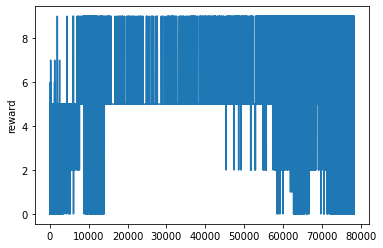

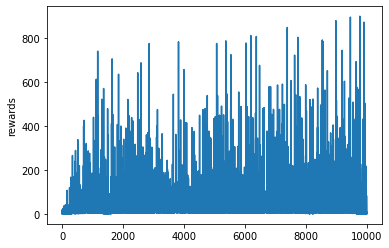

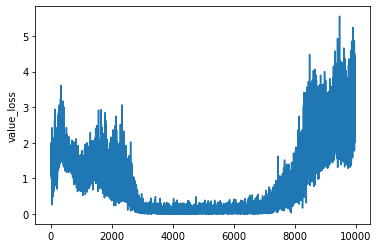

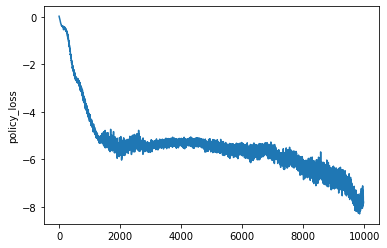

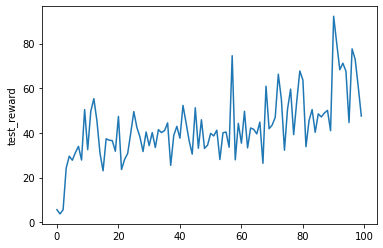

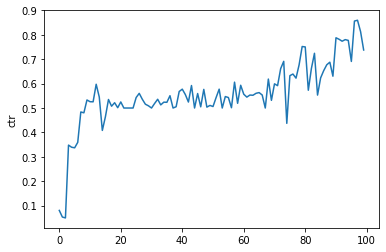

In [5]:
def getInfo():
    '''返回六个列表,分别用于保存reward/rewards/value_loss/policy_loss/test_reward/ctr'''
    info = list()
    fileNames = [
        './reward_record.pkl',
        './rewards_record.pkl',
        './value_loss_record.pkl',
        './policy_loss.pkl',
        './test_reward_record.pkl',
        './ctr_record.pkl']  # 文件的名字
    for name in fileNames:
        with open(name, 'rb') as f:
            item = pickle.load(f)
            info.append(item)
    return info

reward_record, rewards, value_loss_record, policy_loss_record, test_reward_record,ctr_record = getInfo()

plt.plot(reward_record)
plt.ylabel('reward')
plt.show()

plt.plot(rewards)
plt.ylabel('rewards')
plt.show()

plt.plot(value_loss_record)
plt.ylabel('value_loss')
plt.show()

plt.plot(policy_loss_record)
plt.ylabel('policy_loss')
plt.show()

plt.plot(test_reward_record)
plt.ylabel('test_reward')
plt.show()

plt.plot(ctr_record)
plt.ylabel('ctr')
plt.show()

In [2]:
input_dim = 91
output_dim = 128
layer_num = 1
batch_num = 1
sequence_l = 1 #不太清楚
action_dim = 27


rnn = nn.LSTM(input_dim, output_dim, layer_num)
input = torch.randn(batch_num, sequence_l, input_dim)
h0 = torch.randn(layer_num, batch_num, output_dim)
c0 = torch.randn(layer_num, batch_num, output_dim)
output, (hn, cn) = rnn(input, (h0, c0))

l2 = nn.Linear(output_dim, action_dim)
action = l2(output)

print(output.shape)
print(hn.shape)
print(action.shape)

torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 27])


In [46]:
class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        print('x: ', x.shape)
        shape = [-1] + [1] * (x.dim() - 1)
        print('shape ', shape)
        
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        print('mean ', mean.shape)
        
        std = x.view(x.size(0), -1).std(1).view(*shape)
        print('std: ', std.shape)
        
        y = (x - mean) / (std + self.eps)
        print('y', y.shape)
        
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            print('shape: ', shape)
            print('gamma:', self.gamma.view(*shape).shape)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
            print('y:', y.shape)
            
        return y

nn.LayerNorm = LayerNorm

In [55]:
a = torch.randn(1,27)
b = torch.randn(1,1,27)
# print(a.shape)
# print(b.shape)

l = nn.Linear(27, 128)
ln1 = nn.LayerNorm(128)
a = l(b)
res_ln = ln1(a)
print(res_ln.shape)

x:  torch.Size([1, 1, 128])
shape  [-1, 1, 1]
mean  torch.Size([1, 1, 1])
std:  torch.Size([1, 1, 1])
y torch.Size([1, 1, 128])
shape:  [1, -1, 1]
gamma: torch.Size([1, 128, 1])
y: torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


In [58]:
# shape = [1, -1] + [1] * (b.dim() - 2)
shape = [1, 1, -1]
gamma = nn.Parameter(torch.Tensor(128).uniform_())
(gamma.view(*shape) * l(b)).shape

torch.Size([1, 1, 128])